In [1]:
hyperparameters = {
    "learning_rate": 5e-4,
    "batch_size": 64,
    "embed_dim": 128,
    "num_heads": 4,
    "num_layers": 2,
    "dropout": 0.2,
    "ff_dim": 1024,
    "epochs": 300,
    "weight_decay": 1e-4,
    "k-mers": 6,
    "max_len": 196,
}

info = {
    "dataset_size": "100K",
    "precision": "FP16",
    "dir_name": "Ref_Alt_MutType_Model",
    "run": "Fifth Run",
    "ce_mut": "weighted"
}

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

data_path = f"/content/drive/MyDrive/dataset/{info['dataset_size']}.csv"

data = pd.read_csv(data_path)
data.shape

(100000, 10)

In [4]:
data['alt'] = data['alt'].map({'A': 0, 'T': 1, 'G': 2, 'C': 3})

In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['mutation_type'] = encoder.fit_transform(data['mutation_type'])

In [6]:
x = data['sequence']
y_alt = data['alt']
y_type = data['mutation_type']

In [7]:
def get_codon(seq, k=hyperparameters['k-mers']):
    return [seq[i:i+k] for i in range(len(seq) - k + 1)]

vocab = {'<PAD>': 0, '<UNK>': 1}

for seq in data['sequence']:
    for codons in get_codon(seq.lower()):
        if codons not in vocab:
            vocab[codons] = len(vocab)
        else:
            continue

def get_tensor(text):
    return [vocab.get(codons.lower(), vocab['<UNK>']) for codons in get_codon(text)]

In [8]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
  def __init__(
      self,
      x,
      y_alt,
      y_type
  ):
    self.x_frame = x
    self.y_alt_frame = y_alt
    self.y_type_frame = y_type

  def __len__(self):
    return len(self.x_frame)

  def __getitem__(self, index):
    x = torch.tensor(get_tensor(self.x_frame[index]), dtype=torch.long)
    y_alt = torch.tensor(self.y_alt_frame[index], dtype=torch.long)
    y_type = torch.tensor(self.y_type_frame[index], dtype=torch.long)

    return (
      x,
      y_alt,
      y_type
    )

In [9]:
dataset = CustomDataset(
    x,
    y_alt,
    y_type
)

In [10]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=hyperparameters['batch_size'],
    shuffle=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=hyperparameters['batch_size']
)

In [ ]:
from torch import nn
import math

class PositionalEncoding(nn.Module):
    def __init__(
        self, 
        embed_dim, 
        max_len=5000
    ):
        super().__init__()

        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len).unsqueeze(1)

        div_term = torch.exp((torch.arange(0, embed_dim, 2)) * (-math.log(10000.0) / embed_dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

class Transformer(nn.Module):
    def __init__(
            self, 
            embed_dim=512, 
            num_heads=8, 
            num_layers=6, 
            ff_dim=2048, 
            dropout=0.1, 
            vocab_size=10000, 
            max_len=5000
        ):
        super(Transformer, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.position_encoding = PositionalEncoding(embed_dim=embed_dim, max_len=max_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=num_layers
        )

        self.y_alt_out = nn.Linear(embed_dim, 4)
        self.y_mut_out = nn.Linear(embed_dim, 12)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.position_encoding(x)

        x = self.encoder(x)
        x = x.mean(dim=1)

        y_alt_out = self.y_alt_out(x)
        y_mut_out = self.y_mut_out(x)

        return (
            y_alt_out,
            y_mut_out
        )

In [27]:
model = Transformer(
    embed_dim=hyperparameters['embed_dim'],
    num_heads=hyperparameters['num_heads'],
    num_layers=hyperparameters['num_layers'],
    ff_dim=hyperparameters['ff_dim'],
    dropout=hyperparameters['dropout'],
    vocab_size=len(vocab),
    max_len=hyperparameters['max_len']
)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Transformer(
  (embeddings): Embedding(4098, 128)
  (position_encoding): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=1024, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=1024, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (y_alt_out): Linear(in_features=128, out_features=4, bias=True)
  (y_mut_out): Linear(in_features=128, out_features=12, bias=True)
)

In [29]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {num_params}")

Total trainable parameters: 1186320


In [30]:
class_counts = data['mutation_type'].value_counts().sort_index().values
weights = 1. / torch.tensor(class_counts, dtype=torch.float)
weights = weights / weights.sum()
weights = weights.to(device)

In [31]:
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR

ce_alt = nn.CrossEntropyLoss()
ce_mut = nn.CrossEntropyLoss(weight=weights)

optimizer = optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'], weight_decay=hyperparameters['weight_decay'])
scaler = torch.cuda.amp.GradScaler()

scheduler = CosineAnnealingLR(
    optimizer,
    T_max=len(train_loader) * hyperparameters['epochs']
)

/tmp/ipython-input-1754984498.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [32]:
def train32(
    model,
    loader,
    ce_alt,
    ce_mut,
    optimizer
):

    model.train()

    running_loss, correct_alt, correct_mut, total = 0.0, 0, 0, 0, 0

    for x, y_alt, y_mut in loader:
        optimizer.zero_grad()

        x = x.to(device)
        y_alt = y_alt.to(device)
        y_mut = y_mut.to(device)

        y_alt_out, y_mut_out = model(x)

        loss_alt = ce_alt(y_alt_out, y_alt)
        loss_mut = ce_mut(y_mut_out, y_mut)

        loss = (1.0 * loss_alt) + (1.5 * loss_mut)

        pred_alt = torch.argmax(y_alt_out, dim=1)
        correct_alt += (pred_alt == y_alt).sum().item()

        pred_mut = torch.argmax(y_mut_out, dim=1)
        correct_mut += (pred_mut == y_mut).sum().item()

        total += len(x)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * len(x)

    accuracy_alt = correct_alt / total
    accuracy_mut = correct_mut / total

    return (
        running_loss/len(loader.dataset),
        accuracy_alt,
        accuracy_mut,
    )

def train16(
        model,
        loader,
        ce_alt,
        ce_mut,
        optimizer,
        scaler,
        scheduler
    ):

    model.train()

    running_loss, correct_alt, correct_mut, total = 0.0, 0, 0, 0

    for x, y_alt, y_mut in loader:
        optimizer.zero_grad()

        x = x.to(device)
        y_alt = y_alt.to(device)
        y_mut = y_mut.to(device)

        with torch.cuda.amp.autocast():
            y_alt_out, y_mut_out = model(x)

            loss_alt = ce_alt(y_alt_out, y_alt)
            loss_mut = ce_mut(y_mut_out, y_mut)

            loss = (1.0 * loss_alt) + (1.5 * loss_mut)

        pred_alt = torch.argmax(y_alt_out, dim=1)
        correct_alt += (pred_alt == y_alt).sum().item()

        pred_mut = torch.argmax(y_mut_out, dim=1)
        correct_mut += (pred_mut == y_mut).sum().item()

        total += len(x)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()

        running_loss += loss.item() * len(x)


    accuracy_alt = correct_alt / total
    accuracy_mut = correct_mut / total

    return (
        running_loss/len(loader.dataset),
        accuracy_alt,
        accuracy_mut,
    )

In [35]:
def validation(
        model,
        loader,
        ce_alt,
        ce_mut
):
    model.eval()

    running_loss, correct_alt, correct_mut, total = 0.0, 0, 0, 0

    with torch.no_grad():
        for x, y_alt, y_mut in loader:
                x = x.to(device)
                y_alt = y_alt.to(device)
                y_mut = y_mut.to(device)

                if info['precision'] == 'FP16':
                        with torch.cuda.amp.autocast():
                                y_alt_out, y_mut_out = model(x)

                                loss_alt = ce_alt(y_alt_out, y_alt)
                                loss_mut = ce_mut(y_mut_out, y_mut)

                                loss = (1.0 * loss_alt) + (1.5 * loss_mut)
                else:
                        y_alt_out, y_mut_out = model(x)

                        loss_alt = ce_alt(y_alt_out, y_alt)
                        loss_mut = ce_mut(y_mut_out, y_mut)

                        loss = (1.0 * loss_alt) + (1.5 * loss_mut)

                running_loss += loss.item() * len(x)

                pred_alt = torch.argmax(y_alt_out, dim=1)
                correct_alt += (pred_alt == y_alt).sum().item()

                pred_mut = torch.argmax(y_mut_out, dim=1)
                correct_mut += (pred_mut == y_mut).sum().item()

                total += len(x)

        accuracy_alt = correct_alt / total
        accuracy_mut = correct_mut / total

        return (
                running_loss/len(loader.dataset),
                accuracy_alt,
                accuracy_mut,
        )

In [36]:
import os

patience = 10
best_val_loss = float('inf')
counter = 0
early_stop = False

train_loss_history = []
train_alt_acc_history = []
train_mut_acc_history = []

validation_loss_history = []
validation_alt_acc_history = []
validation_mut_acc_history = []

save_dir = f"/content/drive/MyDrive/{info['dir_name']}"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(1, hyperparameters['epochs']+1):
    if info['precision'] == 'FP16':
      train_loss, train_accuracy_alt, train_accuracy_mut = train16(
            model,
            train_loader,
            ce_alt,
            ce_mut,
            optimizer,
            scaler,
            scheduler
        )
    else:
      train_loss, train_accuracy_alt, train_accuracy_mut = train32(
          model,
          train_loader,
          ce_alt,
          ce_mut,
          optimizer
      )

    validation_loss, validation_accuracy_alt, validation_accuracy_mut = validation(
        model,
        test_loader,
        ce_alt,
        ce_mut
    )

    train_loss_history.append(train_loss)
    train_alt_acc_history.append(train_accuracy_alt)
    train_mut_acc_history.append(train_accuracy_mut)

    validation_loss_history.append(validation_loss)
    validation_alt_acc_history.append(validation_accuracy_alt)
    validation_mut_acc_history.append(validation_accuracy_mut)

    print(f"""
    Epoch ({epoch}/{hyperparameters['epochs']}):
    ----------------------------------------
    Training:
    Loss                      = {train_loss:.4f}
    Accuracy (Alternate)      = {train_accuracy_alt:.2f}%
    Accuracy (Mutation Type)  = {train_accuracy_mut:.2f}%

    Validation:
    Loss                      = {validation_loss:.4f}
    Accuracy (Alternate)      = {validation_accuracy_alt:.2f}%
    Accuracy (Mutation Type)  = {validation_accuracy_mut:.2f}%
    """)

    if (epoch+1) % 10 == 0:
      checkpoint_path = f"{save_dir}/model_{info['run']}_epoch_{epoch+1}.pth"
      torch.save({
          'epoch': epoch+1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'Training Loss': train_loss,
          'Training Accuracy Alternate': train_accuracy_alt,
          'Training Accuracy Muation': train_accuracy_mut,
          'Validation Loss': validation_loss,
          'Validation Accuracy Alternate': validation_accuracy_alt,
          'Validation Accuracy Muation': validation_accuracy_mut
      }, checkpoint_path)
      print(f"Model saved at {checkpoint_path}")


    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        counter = 0
        continue
    else:
        counter += 1
        print(f"No improvement in val loss Counter = {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered!")
            early_stop = True
            break


/tmp/ipython-input-372520582.py:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipython-input-1152235012.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():



    Epoch (1/300):
    ----------------------------------------
    Training:
    Loss                      = 4.0575
    Accuracy (Alternate)      = 0.48%
    Accuracy (Mutation Type)  = 0.27%

    Validation:
    Loss                      = 3.7376
    Accuracy (Alternate)      = 0.53%
    Accuracy (Mutation Type)  = 0.37%
    

    Epoch (2/300):
    ----------------------------------------
    Training:
    Loss                      = 3.3383
    Accuracy (Alternate)      = 0.56%
    Accuracy (Mutation Type)  = 0.35%

    Validation:
    Loss                      = 3.2953
    Accuracy (Alternate)      = 0.58%
    Accuracy (Mutation Type)  = 0.39%
    

    Epoch (3/300):
    ----------------------------------------
    Training:
    Loss                      = 2.9315
    Accuracy (Alternate)      = 0.60%
    Accuracy (Mutation Type)  = 0.39%

    Validation:
    Loss                      = 2.9957
    Accuracy (Alternate)      = 0.61%
    Accuracy (Mutation Type)  = 0.39%
    

    Ep

In [37]:
from sklearn.metrics import classification_report

def get_predictions_and_labels(model, loader):
    model.eval()
    all_y_true_alt = []
    all_y_true_mut = []

    all_y_pred_alt = []
    all_y_pred_mut = []

    with torch.no_grad():
        for x, y_alt, y_mut in loader:
            x = x.to(device)
            y_alt= y_alt.to(device)
            y_mut = y_mut.to(device)

            y_alt_out, y_mut_out = model(x)

            _, pred_alt = torch.max(y_alt_out, 1)
            _, pred_mut = torch.max(y_mut_out, 1)

            all_y_true_alt.extend(y_alt.cpu().numpy())
            all_y_true_mut.extend(y_mut.cpu().numpy())

            all_y_pred_alt.extend(pred_alt.cpu().numpy())
            all_y_pred_mut.extend(pred_mut.cpu().numpy())

    return (
        (all_y_true_alt, all_y_pred_alt),
        (all_y_true_mut, all_y_pred_mut)
    )

In [ ]:
from sklearn.metrics import classification_report

(y_alt_true, y_alt_pred), (y_mut_true, y_mut_pred) = get_predictions_and_labels(model, test_loader)

print("\n" + "="*60)
print("Classification Report Summary")
print("="*60)

print("\n[1] Classification Report — Alternate Label")
print("-" * 60)
print(classification_report(y_alt_true, y_alt_pred))

print("\n[2] Classification Report — Mutation Type Label")
print("-" * 60)
print(classification_report(y_mut_true, y_mut_pred))

print("="*60 + "\n")



Classification Report Summary

[1] Classification Report — Alternate Label
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.62      0.69      0.65      5724
           1       0.61      0.68      0.65      5767
           2       0.61      0.49      0.54      4261
           3       0.60      0.53      0.56      4248

    accuracy                           0.61     20000
   macro avg       0.61      0.60      0.60     20000
weighted avg       0.61      0.61      0.61     20000


[2] Classification Report — Mutation Type Label
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.22      0.26      0.24       740
           1       0.69      0.38      0.49      2336
           2       0.17      0.45      0.25       561
           3       0.20      0.36      0.26      1074
           4       0.25      0.33      0.28    

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_alt_true, y_alt_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_mut_true, y_mut_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=45)


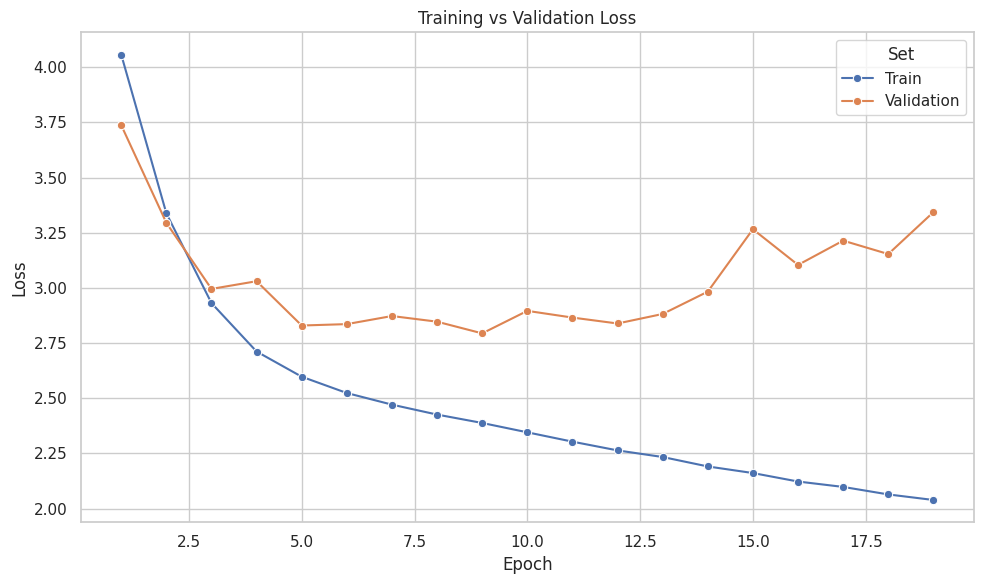

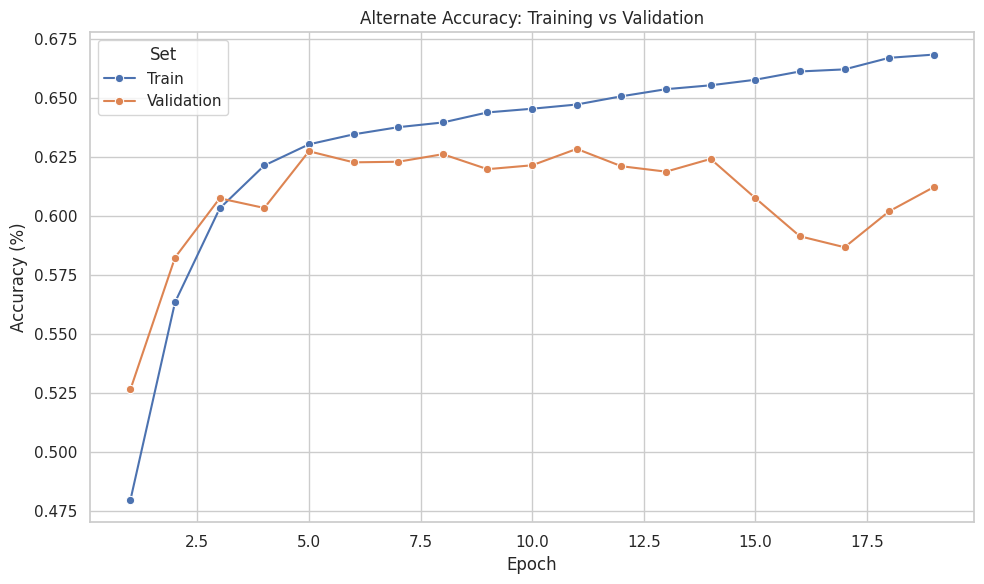

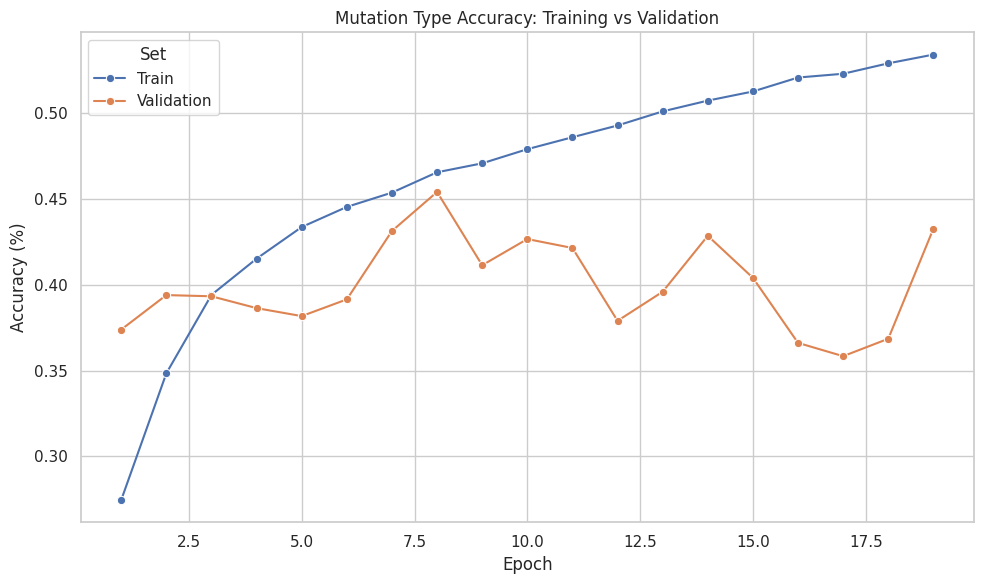

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

epochs = list(range(1, len(train_loss_history) + 1))

data = {
    'Epoch': epochs * 2,
    'Loss': train_loss_history + validation_loss_history,
    'Accuracy_Alt': train_alt_acc_history + validation_alt_acc_history,
    'Accuracy_Mut': train_mut_acc_history + validation_mut_acc_history,
    'Set': ['Train'] * len(epochs) + ['Validation'] * len(epochs)
}

df = pd.DataFrame(data)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Epoch', y='Loss', hue='Set', marker='o')
plt.title("Training vs Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Epoch', y='Accuracy_Alt', hue='Set', marker='o')
plt.title("Alternate Accuracy: Training vs Validation")
plt.ylabel("Accuracy (%)")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Epoch', y='Accuracy_Mut', hue='Set', marker='o')
plt.title("Mutation Type Accuracy: Training vs Validation")
plt.ylabel("Accuracy (%)")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()